In [1]:
pip install pyod shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 17.0 MB/s 
     |████████████████████████████████| 575 kB 80.9 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=eac82acff40f58ce25a3ecfd50f688e0d35d85533449208e4c92b0c9b8c9427e
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.ecod import ECOD
import matplotlib.pyplot as plt
import seaborn as sn
from pickle import dump, load
from urllib.request import urlopen
import shap

#### Data Loading

In [3]:
df=pd.read_pickle('https://drive.google.com/uc?id=1hILz_vBupbUaEICj_Xgw933g5Har2hpW')

In [4]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPDMIN_hpa,VPDMAX_hpa
0,0.026572,0.256588,0.611242,0.252408,0.0,0.307359,0.377970,0.439271,0.350840,0.183593,0.234687,0.398496,0.917252,0.147619,0.200000,0.106533,0.234453
1,0.026572,0.306701,0.553827,0.267139,0.0,0.411255,0.431965,0.443320,0.487395,0.015900,0.099077,0.416040,0.913973,0.114286,0.211321,0.116937,0.207287
2,0.088574,0.177170,0.686698,0.265439,0.0,0.409091,0.460043,0.497976,0.449580,0.583804,0.335023,0.478697,0.928806,0.161905,0.290566,0.166875,0.245912
3,0.090345,0.650015,0.374516,0.460907,0.0,0.283550,0.280778,0.281377,0.279412,0.352868,0.308407,0.443609,0.790320,0.157143,0.222642,0.081149,0.144586
4,0.091231,0.113036,0.775809,0.553258,0.0,0.270563,0.269978,0.269231,0.250000,0.405914,0.409989,0.433584,0.953630,0.171429,0.211321,0.097794,0.118965


In [5]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (5868, 17)
Test set data size : (1467, 17)


#### Model Training

In [6]:
#No hyperparameteres are available for this model https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.ecod.ECOD
estimator=ECOD(n_jobs=-1)
estimator.fit(X_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.8s finished


ECOD(contamination=0.1, n_jobs=-1)

In [7]:
dump(estimator, open('01_CA_ECOD.pkl', 'wb'))

#### Train set AVG Probability of Being Inlier

In [8]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


Training set Mean :   0.770072
Training set STD :   0.125091


#### Test set AVG Probability of Being Inlier

In [9]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))

Test set Mean :   0.764217
Test set STD :   0.115784


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


#### All set AVG Probability of Being Inlier

In [10]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.768901
All STD :   0.123308


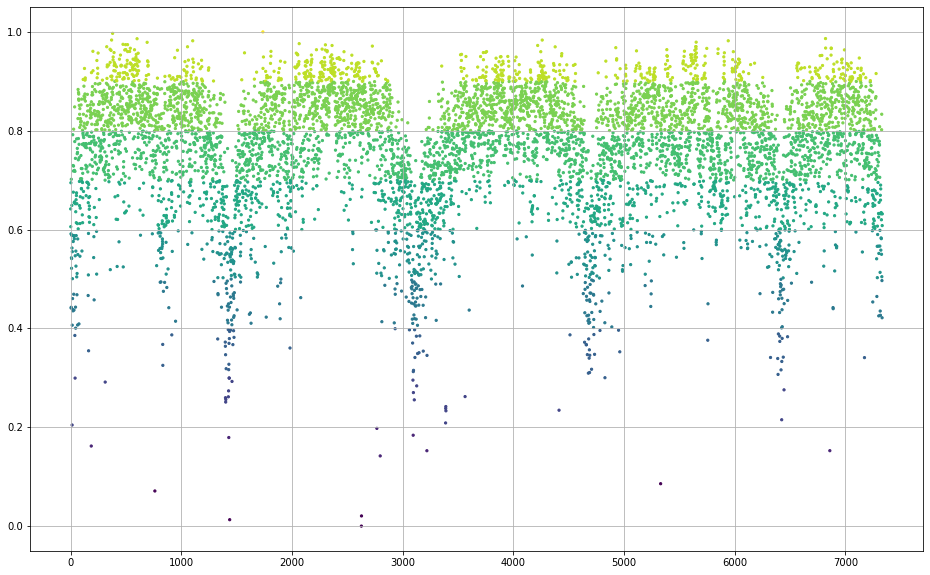

In [11]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()

#### Feature Importance

In [ ]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=500, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.2s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   14.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Don

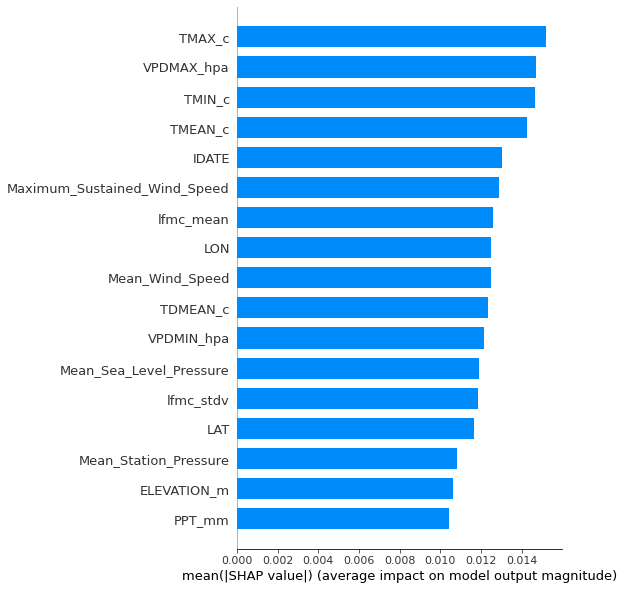

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

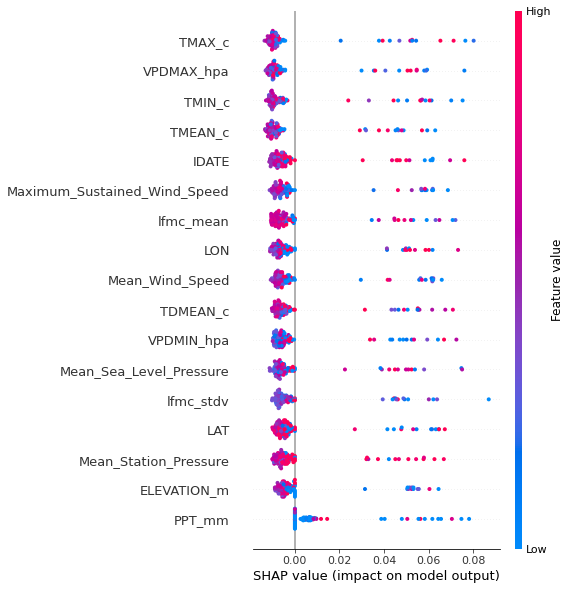

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

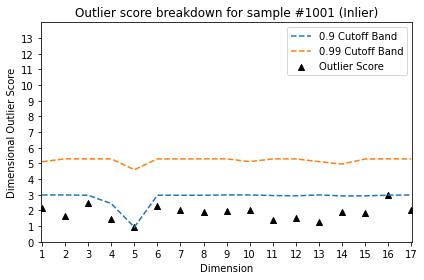

In [ ]:
estimator.explain_outlier(1000)

In [ ]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,IDATE,0.013014
1,LAT,0.011667
2,LON,0.012483
3,ELEVATION_m,0.010611
4,PPT_mm,0.010434
5,TMIN_c,0.014681
6,TMEAN_c,0.014248
7,TMAX_c,0.015204
8,TDMEAN_c,0.012350
9,lfmc_mean,0.012570
